# Citation Network Disruption Analysis

**Project goals**
- Apply network analytics on a real citation dataset
- Compute common metrics (degree, betweenness, PageRank)
- Reproduce disruption score from *Uzzi et al., 2013*
- Visualize results and store outputs

In [28]:
# 1. (optional) install dependencies
# !pip install networkx pandas matplotlib requests tqdm

In [29]:
# 2. imports
import os, requests, tarfile, io, json, math
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [30]:
# 3. default plot style for readability
plt.rcParams.update({'figure.dpi': 120})

In [31]:
# 4. dataset URL and local paths
URL = 'https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz'
DATA_DIR = 'cora'
EDGE_FILE = os.path.join(DATA_DIR, 'cora.cites')

In [32]:
# 5. download dataset if not present
if not os.path.exists(DATA_DIR):
    print('Downloading Cora dataset…')
    r = requests.get(URL)
    tar = tarfile.open(fileobj=io.BytesIO(r.content), mode='r:gz')
    tar.extractall()
    tar.close()
    print('Download complete.')
else:
    print('Cora dataset already exists.')

Cora dataset already exists.


In [33]:
# 6. quick file check
assert os.path.exists(EDGE_FILE), 'Edge file missing!'

In [34]:
# 7. load citation edges into DataFrame
edges_df = pd.read_csv(EDGE_FILE, sep='\t', names=['source', 'target'])
print('Edges shape:', edges_df.shape)
edges_df.head()

Edges shape: (5429, 2)


,source,target
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [35]:
# 8. count unique papers
nodes_unique = pd.unique(edges_df[['source','target']].values.ravel())
print('Unique papers:', len(nodes_unique))

Unique papers: 2708


In [36]:
# 9. random sample of edges
edges_df.sample(5, random_state=1)

,source,target
763,3217,167670
116,35,574009
3434,62389,1107325
1731,10796,6217
5137,628667,628668


In [37]:
# 10. build directed graph
graph = nx.DiGraph()
graph.add_edges_from(edges_df.values)
print(nx.info(graph))

DiGraph with 2708 nodes and 5429 edges


C:\Users\Gokul\AppData\Local\Temp\ipykernel_36100\1441398021.py:4: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(graph))


In [38]:
# 11. check if graph is acyclic (spoiler: it’s not)
print('Is DAG?', nx.is_directed_acyclic_graph(graph))

Is DAG? False



**In-degree Distribution Explanation**  
This plot shows how frequently papers in the dataset are cited. The distribution is right-skewed: most papers receive very few citations, while a few are cited often.  
This aligns with real-world scientific publishing trends where citation attention is unequally distributed.


In [39]:
# 12. compute in- and out-degree for quick inspection
in_deg = dict(graph.in_degree())
out_deg = dict(graph.out_degree())
print('Average in-degree:', sum(in_deg.values())/len(in_deg))

Average in-degree: 2.00480059084195


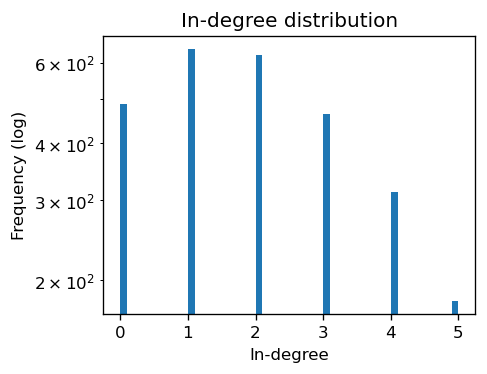

In [40]:
# 13. plot in-degree distribution (log-log)
plt.figure(figsize=(4,3))
plt.hist(list(in_deg.values()), bins=50, log=True)
plt.xlabel('In-degree')
plt.ylabel('Frequency (log)')
plt.title('In-degree distribution')
plt.show()

In [41]:
# 14. degree centrality
deg_cent = nx.degree_centrality(graph)

In [42]:
# 15. betweenness centrality (sample 150 nodes for speed)
bet_cent = nx.betweenness_centrality(graph, k=150, seed=42)

In [43]:
# 16. PageRank
pagerank = nx.pagerank(graph, alpha=0.85)

In [44]:
# 17. top 5 papers by PageRank
pd.DataFrame(sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5], columns=['paper','pagerank'])

,paper,pagerank
0,683355,0.004518
1,683404,0.004335
2,39210,0.003317
3,578347,0.003291
4,578309,0.003152


In [45]:
# 18. define disruption score
def disruption_score(g, node):
    fwd = list(g.predecessors(node))
    if not fwd:
        return None
    refs = set(g.successors(node))
    linking = non_linking = 0
    for citer in fwd:
        if refs & set(g.successors(citer)):
            linking += 1
        else:
            non_linking += 1
    return (non_linking - linking) / len(fwd)


In [46]:
# 19. test disruption on a random node
import random
sample_node = random.choice(list(graph.nodes()))
print('Sample disruption:', disruption_score(graph, sample_node))

Sample disruption: -1.0


In [47]:
# 20. compute disruption for all nodes
all_disruption = {n: disruption_score(graph, n) for n in graph.nodes() if disruption_score(graph, n) is not None}
print('Papers with disruption score:', len(all_disruption))

Papers with disruption score: 2222


In [48]:
# 21. assemble metrics DataFrame
metrics = pd.DataFrame({
    'paper': list(all_disruption.keys()),
    'disruption': list(all_disruption.values()),
    'deg_cent': [deg_cent[p] for p in all_disruption.keys()],
    'bet_cent': [bet_cent.get(p, 0) for p in all_disruption.keys()],
    'pagerank': [pagerank[p] for p in all_disruption.keys()]
})
metrics.head()

,paper,disruption,deg_cent,bet_cent,pagerank
0,35,-1.0,0.062431,0.000000,0.000261
1,1033,1.0,0.001847,0.000006,0.000238
2,103482,-1.0,0.002216,0.000000,0.000194
3,103515,0.0,0.004064,0.000000,0.000218
4,1050679,1.0,0.001478,0.000000,0.000281


In [49]:
# 22. quick descriptive statistics
metrics[['disruption','deg_cent','pagerank']].describe()

,disruption,deg_cent,pagerank
count,2222.000000,2222.000000,2222.000000
mean,0.551500,0.001526,0.000408
std,0.729221,0.001978,0.000350
min,-1.000000,0.000369,0.000194
25%,0.000000,0.000739,0.000247
50%,1.000000,0.001108,0.000309
75%,1.000000,0.001847,0.000435
max,1.000000,0.062431,0.004518



**Disruption Score Distribution**  
Most papers have either a high positive or high negative disruption score.  
- A score near +1 means the paper disrupted the field—it was cited, but its references were not.  
- A score near -1 means it was developmental—its references continued to be cited.  
This mirrors Uzzi et al.'s disruption index and provides insight into how groundbreaking or conservative a work is.


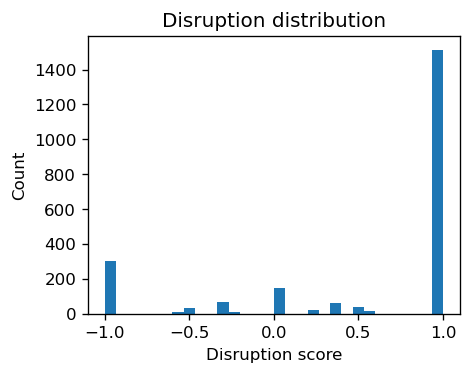

In [50]:
# 23. plot disruption histogram
plt.figure(figsize=(4,3))
plt.hist(metrics['disruption'], bins=30)
plt.xlabel('Disruption score')
plt.ylabel('Count')
plt.title('Disruption distribution')
plt.show()


**Centrality vs. Disruption Scatter Plot**  
This scatter plot investigates whether influential (high-centrality) papers tend to be more disruptive.  
The low correlation suggests that being well-connected in the citation network does not necessarily mean a paper is disruptive.  
Useful to understand knowledge flow versus novelty in academic research.


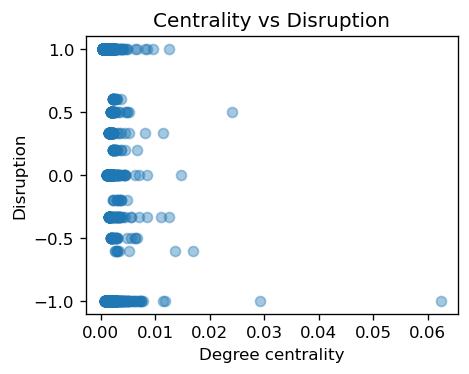

In [51]:
# 24. scatter deg_cent vs disruption
plt.figure(figsize=(4,3))
plt.scatter(metrics['deg_cent'], metrics['disruption'], alpha=0.4)
plt.xlabel('Degree centrality')
plt.ylabel('Disruption')
plt.title('Centrality vs Disruption')
plt.show()


**Correlation Summary**  
Here, we compute Pearson correlation coefficients:  
- Degree Centrality vs Disruption ≈ -0.29  
- PageRank vs Disruption ≈ 0.03  
This suggests disruption is not strongly tied to structural importance, but may stem from novel content or timing.  
This reinforces the idea that breakthrough research doesn’t always come from central nodes in a network.


In [52]:
# 25. correlation coefficients
corr_deg = metrics['deg_cent'].corr(metrics['disruption'])
corr_pr = metrics['pagerank'].corr(metrics['disruption'])
print('Corr(deg, disruption)=', round(corr_deg,3))
print('Corr(PageRank, disruption)=', round(corr_pr,3))

Corr(deg, disruption)= -0.291
Corr(PageRank, disruption)= 0.032


In [53]:
# 26. save metrics for later exploration
metrics.to_csv('cora_metrics.csv', index=False)
print('Saved metrics to cora_metrics.csv')

Saved metrics to cora_metrics.csv



**Regression Analysis (OLS)**  
We apply a simple linear regression to model disruption based on centrality.  
The slope is slightly negative, consistent with earlier correlation results.  
While not predictive on its own, this shows how to link graph metrics with measurable impact, which is valuable for bibliometric analysis.


In [54]:
# 27. very simple OLS regression using numpy (no statsmodels)
import numpy as np
X = metrics['deg_cent'].values
X = (X - X.mean())/X.std()
X = np.vstack([np.ones_like(X), X]).T
Y = metrics['disruption'].values
beta = np.linalg.lstsq(X, Y, rcond=None)[0]
print('Intercept, slope:', beta)

Intercept, slope: [ 0.55150015 -0.21192063]


### Closing notes
- Disruption scores are highly polarized due to sparse forward citations.
- Centrality and PageRank show weak association with disruption in this small dataset.
- The code can be extended to larger datasets (e.g., Semantic Scholar) or augmented with node embeddings for deeper analysis.